# COMP90051 Workshop 3
## Logistic regression
***
In this workshop we'll be implementing L2-regularised logistic regression using `scipy` and `numpy`. 
Our key objectives are:

* to become familiar with the optimisation problem that sits behind L2-regularised logistic regression;
* to apply polynomial basis expansion and recognise when it's useful; and
* to experiment with the effect of L2 regularisation.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### 1. Binary classification data
Let's begin by generating some binary classification data.
To make it easy for us to visualise the results, we'll stick to a two-dimensional feature space.

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


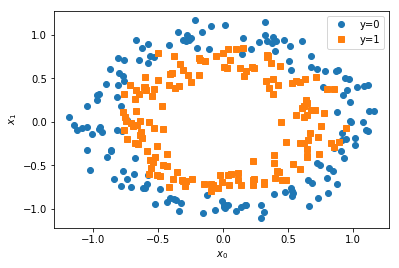

In [2]:
from sklearn.datasets import make_circles
X, Y = make_circles(n_samples=300, noise=0.1, factor=0.7, random_state=90051)
plt.plot(X[Y==0,0], X[Y==0,1], 'o', label = "y=0")
plt.plot(X[Y==1,0], X[Y==1,1], 's', label = "y=1")
plt.legend()
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.show()

**Question:** What's interesting about this data? Do you think logistic regression will perform well?

In preparation for fitting and evaluating a logistic regression model, we randomly partition the data into train/test sets. We use the `train_test_split` function from `sklearn`.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=90051)
print("Training set has {} instances. Test set has {} instances.".format(X_train.shape[0], X_test.shape[0]))

Training set has 201 instances. Test set has 99 instances.


### 2. Logistic regression objective function

Recall from lectures, that logistic regression models the distribution of the binary class $y$ *conditional* on the feature vector $\mathbf{x}$ as
$$
y | \mathbf{x} \sim \mathrm{Bernoulli}[\sigma(\mathbf{w}^T \mathbf{x} + b)]
$$
where $\mathbf{w}$ is the weight vector, $b$ is the bias term and $\sigma(z) = 1/(1 + e^{-z})$ is the logistic function.
To simplify the notation, we'll collect the model parameters $\mathbf{w}$ and $b$ in a single vector $\mathbf{v} = [b, \mathbf{w}]$.

Fitting this model amounts to choosing $\mathbf{v}$ that minimises the sum of cross-entropies over the instances ($i = 1,\ldots,n$) in the training set
$$
\begin{align}
    f_\mathrm{cross-ent}(\mathbf{v}; \mathbf{X}, \mathbf{Y}) = - \sum_{i = 1}^{n} \left\{ y_i \log \sigma(\mathbf{w}^T \mathbf{x}_i + b) + (1 - y_i) \log (1 - \sigma(\mathbf{w}^T \mathbf{x}_i + b)) \right\}
\end{align}
$$

Often a regularisation term of the form $f_\mathrm{reg}(\mathbf{w}; \lambda) = \frac{1}{2} \lambda \mathbf{w}^T \mathbf{w}$ is added to the objective to penalize large weights (this can help to prevent overfitting). Note that $\lambda \geq 0$ controls the strength of the regularisation term.

Putting this together, our goal is to minimise the following objective function with respect to $\mathbf{w}$ and $b$:
$$
f(\mathbf{v}; \mathbf{X}, \mathbf{Y}, \lambda) = f_\mathrm{reg}(\mathbf{w}; \lambda) + f_\mathrm{cross-ent}(\mathbf{v}; \mathbf{X}, \mathbf{Y})
$$

**Question:** Why aren't we regularising the entire parameter vector $\mathbf{v}$? Notice that only $\mathbf{w}$ is included in $f_\mathrm{reg}$—in other words $b$ is excluded from regularisation. 

We're going to find a solution to this minimisation problem using the BFGS algorithm (named after the inventors Broyden, Fletcher, Goldfarb and Shanno). BFGS is a "hill-climbing" algorithm like gradient descent, however it additionally makes use of second-order derivative information (by approximating the Hessian). It converges in fewer iterations than gradient descent (it's convergence rate is *superlinear* whereas gradient descent is only *linear*).

We'll use an implementation of BFGS provided in `scipy` called `fmin_bfgs`. The algorithm requires two functions as input: (i) a function that evaluates the objective $f(\mathbf{v}; \ldots)$ and (ii) a function that evalutes the gradient $\nabla_{\mathbf{v}} f(\mathbf{v}; \ldots)$.

Let's start by writing a function to compute $f(\mathbf{v}; \ldots)$.

In [20]:
from scipy.special import expit # this is the logistic function

# v: parameter vector
# X: feature matrix
# Y: class labels
# Lambda: regularisation constant
def obj_fn(v, X, Y, Lambda):
    b = v[0]
    w = v[1::]
    prob_1 = expit(np.dot(X,v[1::]) + v[0])
    #reg_term = 1/2 * Lambda * np.dot(w.T, w)
    reg_term = 1/2 * Lambda * w.dot(w)
    cross_entropy_term = - np.dot(Y, np.log(prob_1)) - np.dot(1. - Y, np.log(1. - prob_1))
    return reg_term + cross_entropy_term

Now for the gradient, we use the following result (if you're familiar with vector calculus, you may wish to derive this yourself):
$$
\nabla_{\mathbf{v}} f(\mathbf{v}; \ldots) = \left[\frac{\partial f(\mathbf{w}, b;\ldots)}{\partial b}, \nabla_{\mathbf{w}} f(\mathbf{w}, b; \ldots) \right] = \left[\sum_{i = 1}^{n} \sigma(\mathbf{w}^T \mathbf{x}_i + b) - y_i, \sum_{i = 1}^{n} \lambda \mathbf{w} + (\sigma(\mathbf{w}^T \mathbf{x}_i + b) - y_i)\mathbf{x}_i\right]
$$

The function below implements $\nabla_{\mathbf{v}} f(\mathbf{v}; \ldots)$.

In [21]:
# v: parameter vector
# X: feature matrix
# Y: class labels
# Lambda: regularisation constant
def grad_obj_fn(v, X, Y, Lambda):
    prob_1 = expit(np.dot(X, v[1::]) + v[0])
    grad_b = np.sum(prob_1 - Y)
    grad_w = Lambda * v[1::] + np.dot(prob_1 - Y, X)
    return np.insert(grad_w, 0, grad_b)

### 3. Solving the minimization problem using BFGS

Now that we've implemented functions to compute the objective and the gradient, we can plug them into `fmin_bfgs`.
Specifically, we define a function `my_logistic_regression` which calls `fmin_bfgs` and returns the optimal weight vector.

In [27]:
from scipy.optimize import fmin_bfgs

# X: feature matrix
# Y: class labels
# Lambda: regularisation constant
# v_initial: initial guess for parameter vector
def my_logistic_regression(X, Y, Lambda, v_initial, disp=True):
    # Function for displaying progress
    def display(v):
        print('v is', v, 'objective is', obj_fn(v, X, Y, Lambda))
    
    return fmin_bfgs(f=obj_fn, fprime=grad_obj_fn, 
                     x0=v_initial, args=(X, Y, Lambda), disp=disp, 
                     callback=display)

Let's try it out!

v is [-0.12895873 -0.08185978  0.02005271] objective is 138.80620162265674
v is [-0.10559965 -0.16360542  0.05028661] objective is 138.71483494120767
v is [-0.10594786 -0.16265682  0.0537028 ] objective is 138.71470747506936
v is [-0.10744929 -0.16393098  0.05382675] objective is 138.7145242035713
v is [-0.10855209 -0.16486892  0.05391878] objective is 138.71448412102714
Optimization terminated successfully.
         Current function value: 138.714484
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9


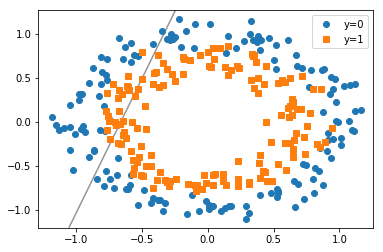

In [28]:
Lambda = 1
#v_initial = ... # fill in a vector of zeros of appropriate length
v_initial = np.zeros(3)
v_opt = my_logistic_regression(X_train, Y_train, Lambda, v_initial)

# Function to plot the data points and decision boundary
def plot_results(X, Y, v, trans_func = None):
    # Scatter plot in feature space
    plt.plot(X[Y==0,0], X[Y==0,1], 'o', label = "y=0")
    plt.plot(X[Y==1,0], X[Y==1,1], 's', label = "y=1")
    
    # Compute axis limits
    x0_lower = X[:,0].min() - 0.1
    x0_upper = X[:,0].max() + 0.1
    x1_lower = X[:,1].min() - 0.1
    x1_upper = X[:,1].max() + 0.1
    
    # Generate grid over feature space
    x0, x1 = np.mgrid[x0_lower:x0_upper:.01, x1_lower:x1_upper:.01]
    grid = np.c_[x0.ravel(), x1.ravel()]
    if (trans_func is not None):
        grid = trans_func(grid) # apply transformation to features
    arg = (np.dot(grid, v[1::]) + v[0]).reshape(x0.shape)
    
    # Plot decision boundary (where w^T x + b == 0)
    plt.contour(x0, x1, arg, levels=[0], cmap="Greys", vmin=-0.2, vmax=0.2)
    plt.legend()
    plt.show()
    
plot_results(X, Y, v_opt)

**Question:** Is the solution what you expected? Is it a good fit for the data?

**Question:** What's the accuracy of this model? Fill in the code below assuming the following decision function
$$
\hat{y} = \begin{cases}
    1, &\mathrm{if} \ p(y = 1|\mathbf{x}) \geq \tfrac{1}{2}, \\
    0, &\mathrm{otherwise}.
\end{cases}
$$

In [ ]:
from sklearn.metrics import accuracy_score
Y_test_pred = ... # fill in
accuracy_score(Y_test, Y_test_pred)

### 4. Adding polynomial features

We've seen that ordinary logistic regression does poorly on this data set, because the data is not linearly separable in the $x_0,x_1$ feature space.

We can get around this problem using basis expansion. In this case, we'll augment the feature space by adding polynomial features of degree 2. In other words, we replace the original feature matrix $\mathbf{X}$ by a transformed feature matrix $\mathbf{\Phi}$ which contains additional columns corresponding to $x_0^2$, $x_0 x_1$ and $x_1^2$. This is done using the function `add_quadratic_features` defined below.

**Note:** There's a built-in function in `sklearn` for adding polynomial features located at `sklearn.preprocessing.PolynomialFeatures`.

In [ ]:
# X: original feature matrix
def add_quadratic_features(X):
    return np.c_[X, X[:,0]**2, X[:,0]*X[:,1], X[:,1]**2]

Phi_train = add_quadratic_features(X_train)
Phi_test = add_quadratic_features(X_test)

Let's apply our custom logistic regression function again on the augmented feature space.

In [ ]:
Lambda = 1
v_initial = ... # fill in a vector of zeros of appropriate length
v_opt = my_logistic_regression(Phi_train, Y_train, Lambda, v_initial)
plot_results(X, Y, v_opt, trans_func=add_quadratic_features)

This time we should get a better result for the accuracy on the test set.

In [ ]:
from sklearn.metrics import accuracy_score
Y_test_pred = ... # fill in
accuracy_score(Y_test, Y_test_pred)

### 5. Effect of regularisation

So far, we've fixed the regularisation constant so that $\lambda = 1$. (Note it's possible to choose an "optimal" value for $\lambda$ by applying cross-validation.)

**Question:** What do you think will happen if we switch the regularisation off? Try setting $\lambda$ to a small value (say $10^{-3}$) and check whether the accuracy of the model is affected.

### 6. Logistic regression using sklearn

Now that you have some insight into the optimisation problem behind logistic regression, you should feel confident in using the built-in implementation in `sklearn` (or other packages).
Note that the `sklearn` implementation handles floating point underflow/overflow more carefully than we have done, and uses faster numerical optimisation algorithms.

In [ ]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C=1)
clf.fit(Phi_train, Y_train)

In [ ]:
from sklearn.metrics import accuracy_score
Y_test_pred = clf.predict(Phi_test)
accuracy_score(Y_test, Y_test_pred)